In [1]:
import matplotlib.pyplot as plt
import numpy as np

from numpy.typing import NDArray

from karabo.imaging.image import Image
from karabo.imaging.imager_base import DirtyImagerConfig
from karabo.imaging.imager_wsclean import (
    WscleanDirtyImager,
    WscleanImageCleaner,
    WscleanImageCleanerConfig,
)
from karabo.imaging.util import project_sky_to_image
from karabo.simulation.sky_model import SkyModel
from karabo.sourcedetection.result import (
    PyBDSFSourceDetectionResult,
)
from karabo.sourcedetection.evaluation import SourceDetectionEvaluation

from karabo.simulation.sample_simulation import run_sample_simulation


# Render plots inline
%matplotlib inline

The RASCIL data directory is not available - continuing but any simulations will fail


#### Sample Simulation

In [2]:
phase_center = [250, -80]
visibilities, sky = run_sample_simulation(phase_center=phase_center, verbose=True)

Getting Sky Survey
Filtering Sky Model
Setting Up Telescope
Setting Up Observation
Generating Visibilities
Creating /tmp/karabo-STM-miro-HHuPfzXsfQ/visibility-thgBvKT4Ah for visibility disk-cache
Saving file to /tmp/karabo-STM-miro-HHuPfzXsfQ/visibility-thgBvKT4Ah/visibility.vis
Parameter 'use_gpus' is None! Using function 'karabo.util.gpu_util.is_cuda_available()'. To overwrite, set 'use_gpus' True or False.
Creating /tmp/karabo-STM-miro-HHuPfzXsfQ/interferometer-QmzbFX5Kwc for interferometer disk-cache.
Saved visibility to /tmp/karabo-STM-miro-HHuPfzXsfQ/visibility-thgBvKT4Ah/visibility.vis


### Imaging

To visualize the source detection, this notebook uses WSClean to obtain images. For other imaging algorithms, please refer to the imaging.ipynb notebook. 

In [3]:
imaging_npixel = 2048
imaging_cellsize = 3.878509448876288e-05

#### WSClean

Creating /tmp/karabo-STM-miro-HHuPfzXsfQ/WSClean-dirty-cZ93DZUEIm for Disk cache for WSClean dirty images
WSClean command: [cd /tmp/karabo-STM-miro-HHuPfzXsfQ/WSClean-dirty-cZ93DZUEIm && OPENBLAS_NUM_THREADS=1 wsclean -size 2048 2048 -scale 0.0022222222222222222deg /tmp/karabo-STM-miro-HHuPfzXsfQ/interferometer-QmzbFX5Kwc/measurements.MS]
WSClean output:
[
WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  100-100 (16)
 == Constructing image ==
Precalculating weights for uniform weighting...
Opening /tmp/karabo-STM-miro-HHuPfzXsfQ/interferometer-QmzbFX5Kwc/measurements.MS, spw 0 with contiguous MS reader.
Mapping measurement set rows... DONE (0-15120; 15120 rows)
Detected 15.5 GB of system memory, usag

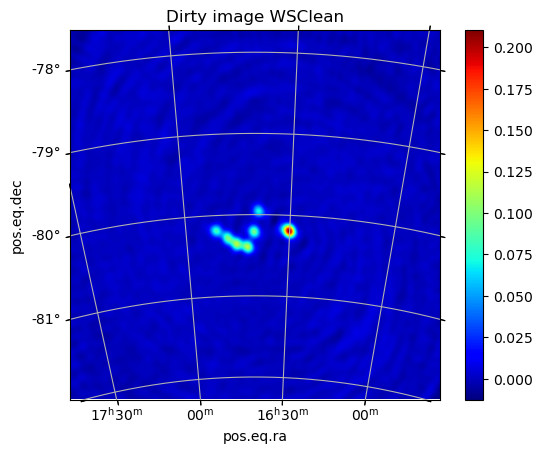

In [4]:
dirty_wsclean = WscleanDirtyImager(
    DirtyImagerConfig(
        imaging_npixel=imaging_npixel,
        imaging_cellsize=imaging_cellsize,
    )
).create_dirty_image(visibilities)
dirty_wsclean.plot(title="Dirty image WSClean")

Creating /tmp/karabo-STM-miro-HHuPfzXsfQ/WSClean-cleaned-2f4EWXi29d for Disk cache for WSClean cleaned images
WSClean command: [cd /tmp/karabo-STM-miro-HHuPfzXsfQ/WSClean-cleaned-2f4EWXi29d && OPENBLAS_NUM_THREADS=1 wsclean -size 2048 2048 -scale 0.0022222222222222222deg -niter 50000 -mgain 0.8 -auto-threshold 3 /tmp/karabo-STM-miro-HHuPfzXsfQ/interferometer-QmzbFX5Kwc/measurements.MS]
WSClean output:
[
WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  100-100 (16)
Reordering /tmp/karabo-STM-miro-HHuPfzXsfQ/interferometer-QmzbFX5Kwc/measurements.MS into 1 x 1 parts.
Reordering: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
Initializing model visibilities: 0%....10%....20%..

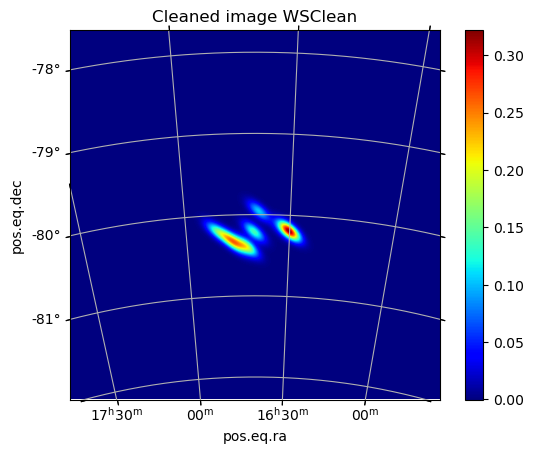

In [5]:
restored_wsclean = WscleanImageCleaner(
    WscleanImageCleanerConfig(
        imaging_npixel=imaging_npixel,
        imaging_cellsize=imaging_cellsize,
    )
).create_cleaned_image(
    ms_file_path=visibilities.ms_file_path,
)
restored_wsclean.plot(title="Cleaned image WSClean")

## Source Detection

In [6]:
ground_truth, sky_idxs = project_sky_to_image(
    sky=sky,
    phase_center=phase_center,
    imaging_cellsize=imaging_cellsize,
    imaging_npixel=imaging_npixel,
    filter_outlier=True,
    invert_ra=True,
)

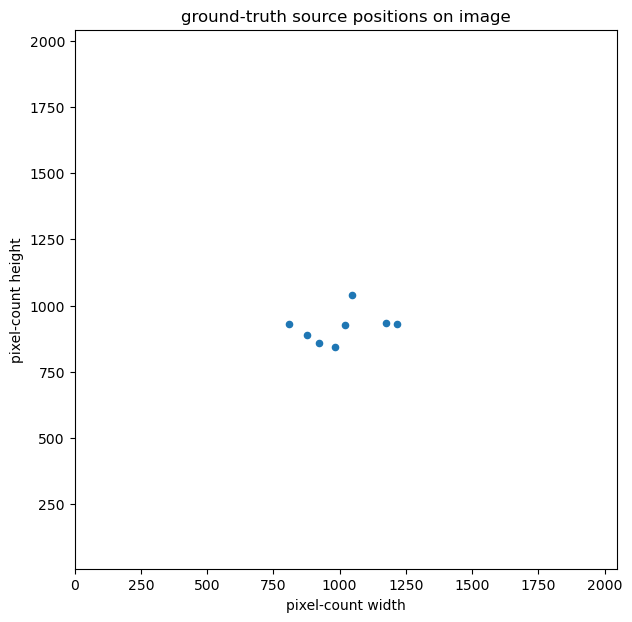

In [7]:
fig, ax = plt.subplots(
    figsize=(7, 7),
)
sc = ax.scatter(ground_truth[0], ground_truth[1], s=20)

# for idx, i in enumerate(range(ground_truth[0].shape[0])):
#     ax.annotate(sky[idx,-1], (ground_truth[0][i], ground_truth[1][i]))

plt.axis("equal")
plt.title("ground-truth source positions on image")
plt.xlim((0, imaging_npixel))
plt.ylim((0, imaging_npixel))
plt.xlabel("pixel-count width")
plt.ylabel("pixel-count height")
plt.show()

In [8]:
def detect_sources_and_evaluate(
    image: Image,
    ground_truth: NDArray[np.float64],
    sky: SkyModel,
    sky_idxs: NDArray[np.int64],
) -> SourceDetectionEvaluation:
    detection_result = PyBDSFSourceDetectionResult.detect_sources_in_image(
        image=image,
        thresh_isl=15,
        thresh_pix=20,
    )

    assignments = (
        SourceDetectionEvaluation.automatic_assignment_of_ground_truth_and_prediction(
            ground_truth=ground_truth.T,
            detected=detection_result.get_pixel_position_of_sources(),
            max_dist=10,
            top_k=3,
        )
    )
    print(assignments)

    sde = SourceDetectionEvaluation(
        sky=sky,
        ground_truth=ground_truth,
        assignments=assignments,
        sky_idxs=sky_idxs,
        source_detection=detection_result,
    )
    sde.plot()

    sde.plot_confusion_matrix()

    return sde

#### WSClean

Creating /tmp/karabo-STM-miro-HHuPfzXsfQ/pybdsf-sdr-0M3LsEhJd9 for pybdsf source-detection-result disk-cache
--> Wrote ASCII file '/tmp/karabo-STM-miro-HHuPfzXsfQ/pybdsf-sdr-0M3LsEhJd9/sources.csv'
--> Wrote file '/tmp/karabo-STM-miro-HHuPfzXsfQ/pybdsf-sdr-0M3LsEhJd9/ch0-result.fits'
[[-1.          8.                 inf]
 [ 0.          4.          1.38947484]
 [ 1.          7.          5.25267146]
 [ 2.          1.          3.38310538]
 [ 3.          0.          1.3881014 ]
 [ 4.          2.          1.40394849]
 [ 5.          6.          6.73457157]
 [ 6.          5.          2.37049909]
 [ 7.          3.          1.40033754]]


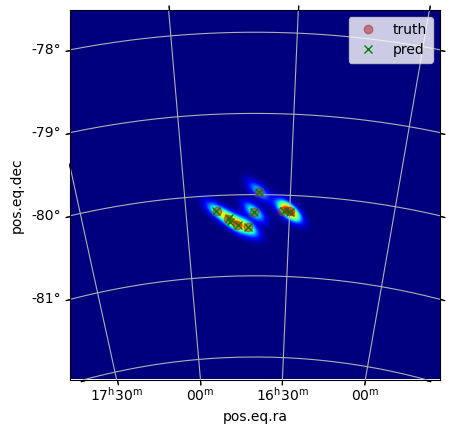

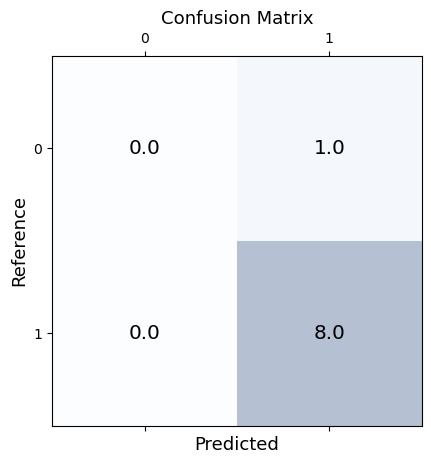

In [9]:
sde_restored_wsclean = detect_sources_and_evaluate(
    image=restored_wsclean, ground_truth=ground_truth, sky=sky, sky_idxs=sky_idxs
)

#### Additional plots

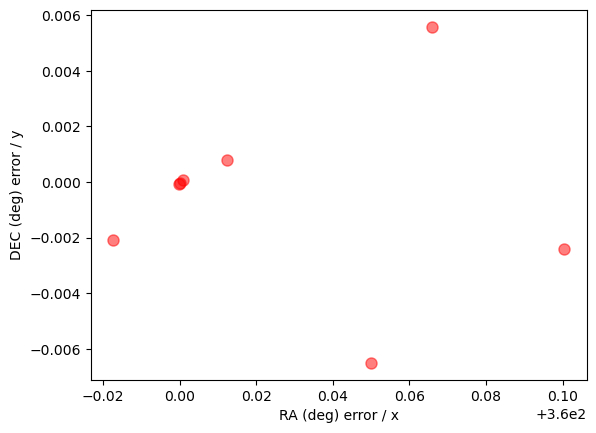

In [10]:
# Plot error ra and dec
sde_restored_wsclean.plot_error_ra_dec()

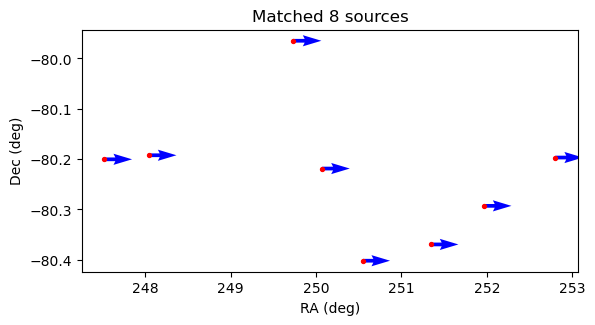

In [11]:
sde_restored_wsclean.plot_quiver_positions()

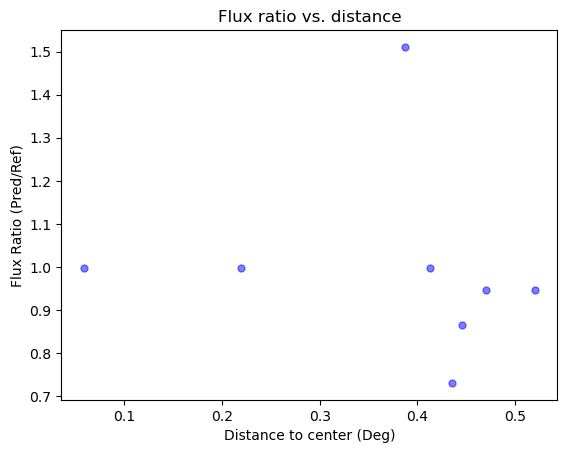

In [12]:
sde_restored_wsclean.plot_flux_ratio_to_distance()

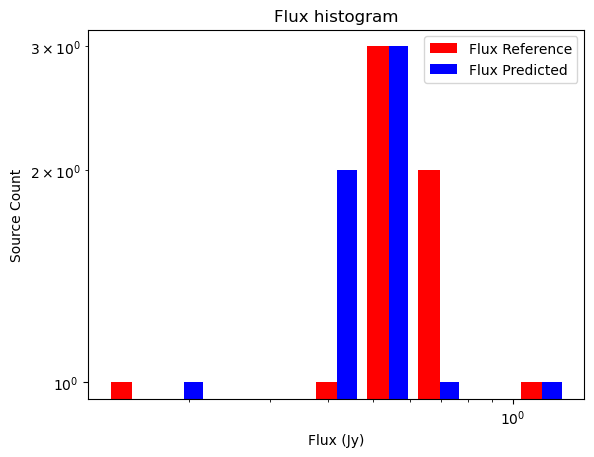

In [13]:
sde_restored_wsclean.plot_flux_histogram()

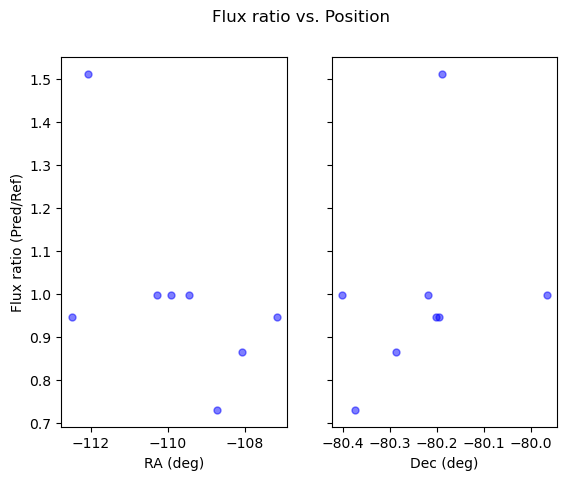

In [14]:
sde_restored_wsclean.plot_flux_ratio_to_ra_dec()